[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train DETR with 🤗 Transformers on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-huggingface-detr-on-custom-dataset.ipynb) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks/blob/main/notebooks/train-huggingface-detr-on-custom-dataset.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2005.12872-b31b1b.svg)](https://arxiv.org/abs/2005.12872) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/AM8D4j9KoaU) [![Roboflow](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on [Niels Rogge](https://github.com/NielsRogge) Fine-tuning DETR on a custom dataset for object detection [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb). In this notebook, we are going to fine-tune [DETR](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to detect players on football field.

- Original DETR paper: https://arxiv.org/abs/2005.12872
- Original DETR repo: https://github.com/facebookresearch/detr

DETR paper - [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) was released in 2020 and since then there were already several follow-ups:
- [Deformable DETR](https://huggingface.co/docs/transformers/main/en/model_doc/deformable_detr)
- [Conditional DETR](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr)
- [YOLOS](https://blog.roboflow.com/train-yolos-transformer-custom-dataset)
- [DETA](https://huggingface.co/docs/transformers/main/en/model_doc/deta)

They all have the same API in 🤗 Transformers library, so training them is mostly equivalent.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Environment setup
- Inference with pre-trained COCO model
- Roboflow Universe
- Preparing a custom dataset
- Download custom dataset
- Create COCO data loaders
- Visualize data entry
- Train model with PyTorch Lightning
- Inference on test dataset
- Evaluation on test dataset
- Save and load model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jun 28 10:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Environment setup

In [3]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/


In [4]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
roboflow: 1.1.0 ; supervision: 0.3.0 ; transformers: 4.30.2 ; pytorch_lightning: 2.0.4


## Inference with pre-trained COCO model

### Download Data

In [5]:
%cd {HOME}
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

/content
--2023-06-28 10:16:19--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.2’

dog.jpeg.2          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2023-06-28 10:16:19 (111 MB/s) - ‘dog.jpeg.2’ saved [106055/106055]



In [6]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

### Load Model

In [7]:
import torch
from transformers import DetaForObjectDetection, DetaImageProcessor,AutoImageProcessor

# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8
repo_name = "jozhang97/deta-swin-large-o365"
image_processor = DetaImageProcessor.from_pretrained(repo_name)
model = DetaForObjectDetection.from_pretrained(repo_name)
model.to(DEVICE)

DetaForObjectDetection(
  (model): DetaModel(
    (backbone): DetaBackboneWithPositionalEncodings(
      (model): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (value): Linear(in_feat

### Inference

{'scores': tensor([0.6914, 0.4287, 0.4039, 0.3634, 0.3546, 0.3322, 0.2601, 0.1989, 0.1770,
        0.1739, 0.1580, 0.1524, 0.1443, 0.1439, 0.1325, 0.1312, 0.1233, 0.1175,
        0.1155, 0.1135, 0.1104, 0.1074, 0.1056, 0.1036, 0.1029],
       device='cuda:0'), 'labels': tensor([ 5, 33,  6,  1, 93, 39, 35, 93,  6, 66, 50, 39, 66, 14, 12, 88, 35,  1,
        20,  1, 39, 93,  6, 50, 56], device='cuda:0'), 'boxes': tensor([[-9.2146e-01,  3.5813e+02,  2.0815e+02,  5.7326e+02],
        [ 6.0984e+01,  6.7336e+02,  1.2460e+02,  7.0035e+02],
        [ 6.2589e+02,  7.3362e+02,  6.9472e+02,  7.8652e+02],
        [ 1.0905e-01,  3.5009e+02,  6.2702e+02,  1.2904e+03],
        [ 5.6555e+01,  2.4775e+02,  6.2670e+02,  9.3538e+02],
        [-3.1103e+00,  6.6579e+02,  4.3977e+02,  1.2750e+03],
        [ 6.2589e+02,  7.3362e+02,  6.9472e+02,  7.8652e+02],
        [ 4.0128e+01,  3.2305e+02,  6.1434e+02,  1.2669e+03],
        [ 6.2217e+02,  7.2034e+02,  6.9959e+02,  7.8851e+02],
        [ 6.2370e+02,  7.24

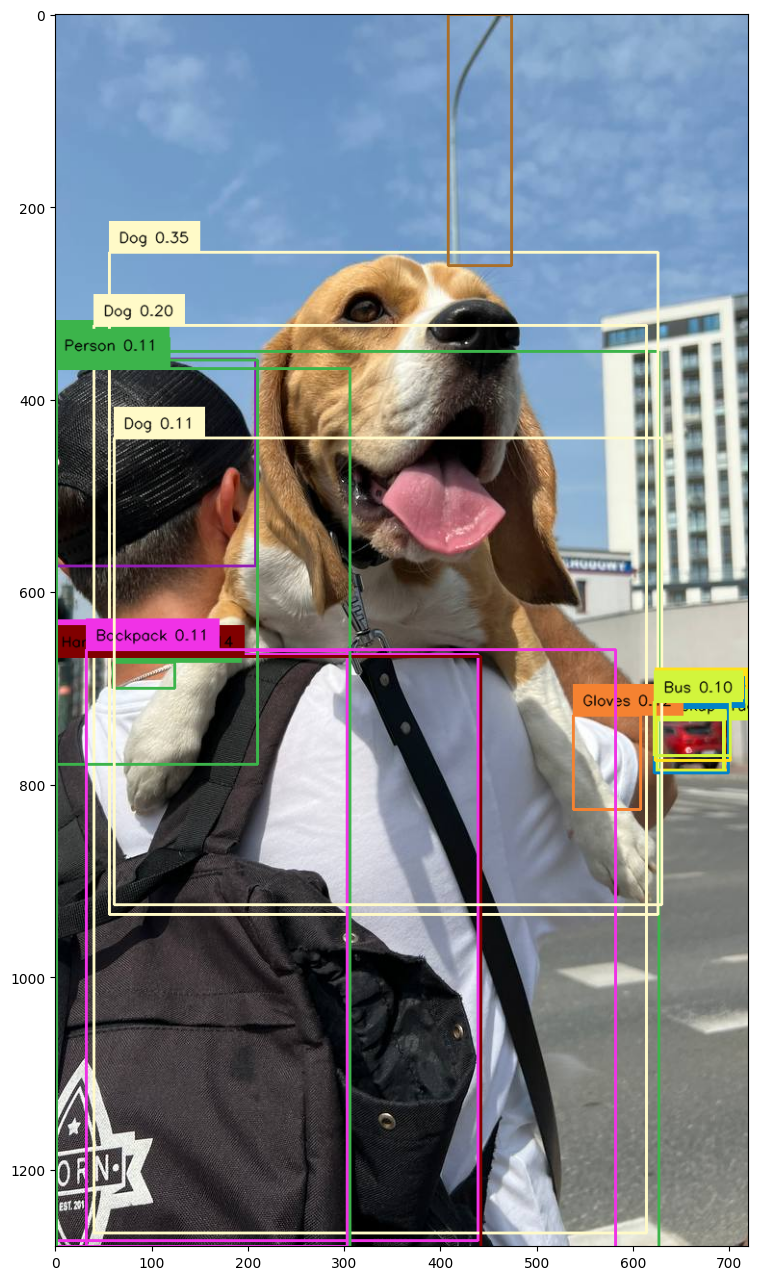

In [8]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread(IMAGE_PATH)
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=0.1,
        target_sizes=target_sizes
    )[0]
    print(results)

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)
print(detections)
labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

**NOTE:** It seems that we have a lot of excess detections. Let's try to filter them out using non-max suppression.

In [9]:
print(labels)

['Hat 0.69', 'Necklace 0.43', 'Car 0.40', 'Person 0.36', 'Dog 0.35', 'Backpack 0.33', 'SUV 0.26', 'Dog 0.20', 'Car 0.18', 'Truck 0.17', 'Van 0.16', 'Backpack 0.15', 'Truck 0.14', 'Handbag/Satchel 0.14', 'Street Lights 0.13', 'Pickup Truck 0.13', 'SUV 0.12', 'Person 0.12', 'Gloves 0.12', 'Person 0.11', 'Backpack 0.11', 'Dog 0.11', 'Car 0.11', 'Van 0.10', 'Bus 0.10']


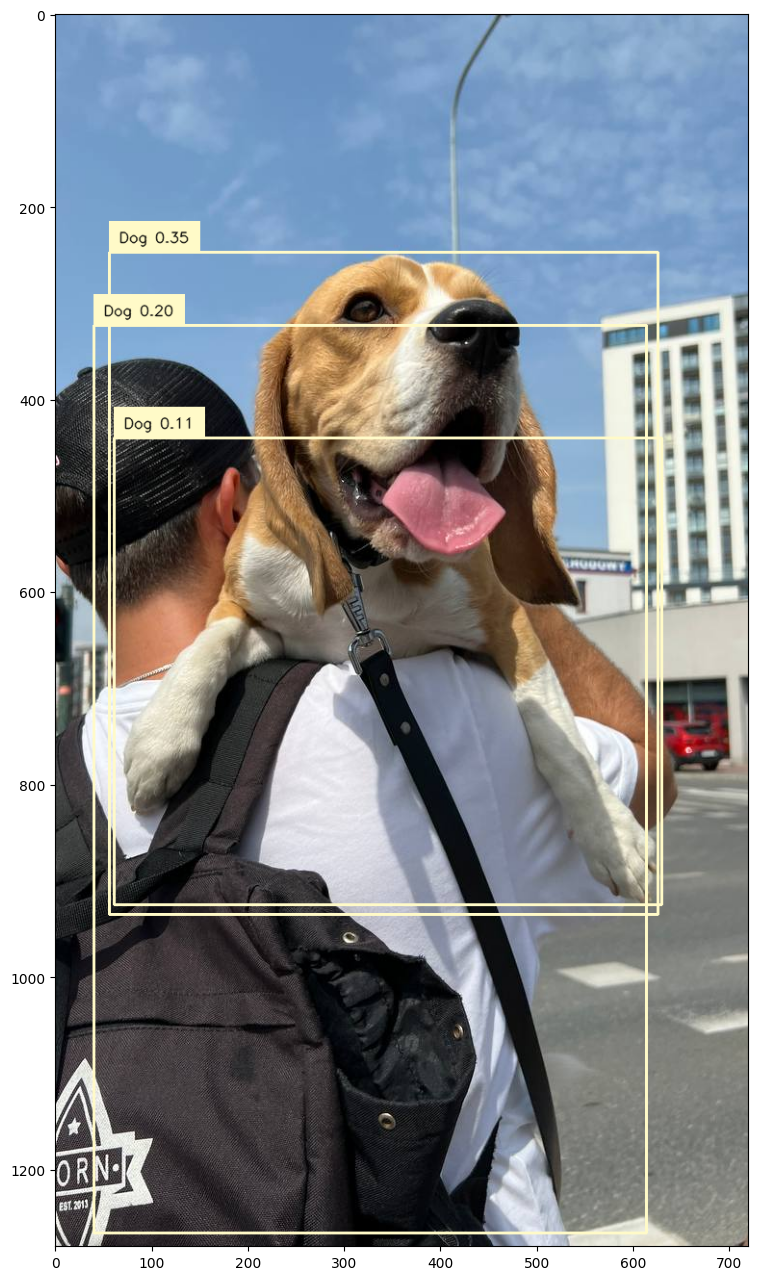

In [10]:
# new_labels = [
#     f"{model.config.id2label[class_id]} {confidence:0.2f}" if model.config.id2label[class_id] == "dog" else None
#     for _, confidence, class_id, _
#     in detections
# ]

# new_detections = [
#     [_1, confidence, class_id, _]  if model.config.id2label[class_id] == "dog" else continue
#     for _1, confidence, class_id, _2
#     in detections
# ]
image = cv2.imread(IMAGE_PATH)
new_labels = []
new_detections = []
wanted_class = "Dog"

for _1, confidence, class_id, _2 in detections:
  cl_name = model.config.id2label[class_id]
  if cl_name.count(wanted_class) > 0:
    new_labels.append(f"{cl_name} {confidence:0.2f}")
    new_detections.append([ _1, confidence, class_id, _2])

box_annotator = sv.BoxAnnotator()
frame_1 = box_annotator.annotate(scene=image, detections=new_detections, labels=new_labels)

%matplotlib inline
sv.show_frame_in_notebook(frame_1, (16, 16))

## Inference + NMS

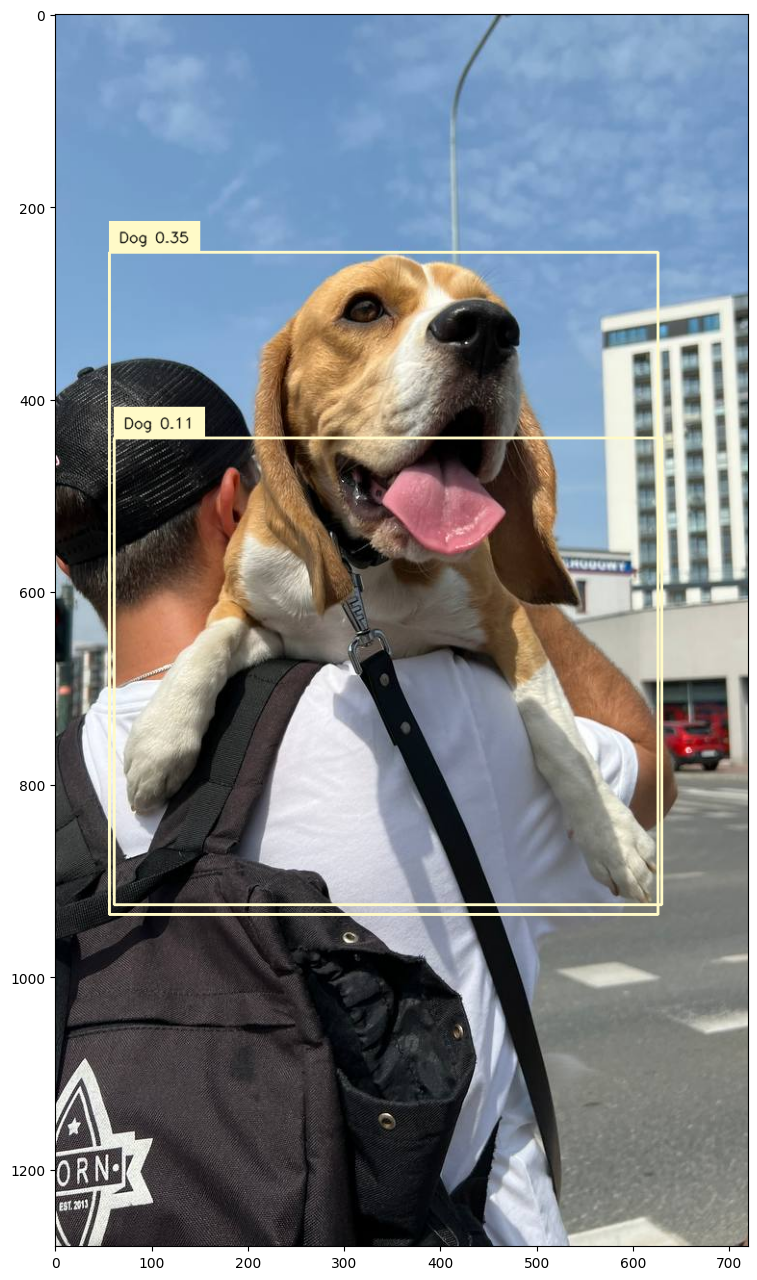

In [11]:
import cv2
import torch
import supervision as sv


with torch.no_grad():
  # load image and predict
  image = cv2.imread(IMAGE_PATH)
  inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
  outputs = model(**inputs)

  # post-process
  target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
  results = image_processor.post_process_object_detection(
      outputs=outputs,
      threshold=0.1,
      target_sizes=target_sizes
  )[0]
  # print(results)


# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)
# print(detections)
box_annotator = sv.BoxAnnotator()

#
new_labels = []
new_detections = []
wanted_class = "Dog"

for _1, confidence, class_id, _2 in detections:
  cl_name = model.config.id2label[class_id]
  if cl_name.count(wanted_class) > 0:
    new_labels.append(f"{cl_name} {confidence:0.2f}")
    new_detections.append([ _1, confidence, class_id, _2])

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=new_detections, labels=new_labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 110,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://ik.imagekit.io/roboflow/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)


## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




## Download custom dataset

[![Roboflow](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

**NOTE:** Note that we download the dataset in `coco` format.

In [12]:
# from getpass import getpass

# ROBOFLOW_API_KEY = getpass('Enter ROBOFLOW_API_KEY secret value: ')

In [15]:
# !mkdir {HOME}/datasets
%cd {HOME}/datasets

# from roboflow import Roboflow
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)
# project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
# dataset = project.version(1).download("coco")
from roboflow import Roboflow
rf = Roboflow(api_key="wyOWnxEvu6h4IkSogVrD")
project = rf.workspace("treedataset-clsqo").project("tree-top-view")
dataset = project.version(6).download("coco")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Tree-Top-View-6 in coco:: 100%|██████████| 1392/1392 [00:01<00:00, 1353.27it/s]


**NOTE:** We can find out where our dataset was saved using the `dataset.location` property.

In [16]:
dataset.location

'/content/datasets/Tree-Top-View-6'

## Create COCO data loaders

In [17]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 1206
Number of validation examples: 118
Number of test examples: 60


## Visualize data entry

**NOTE:** Feel free to reload this cell multiple times. Notebook should display different train set image each time.

Image #703


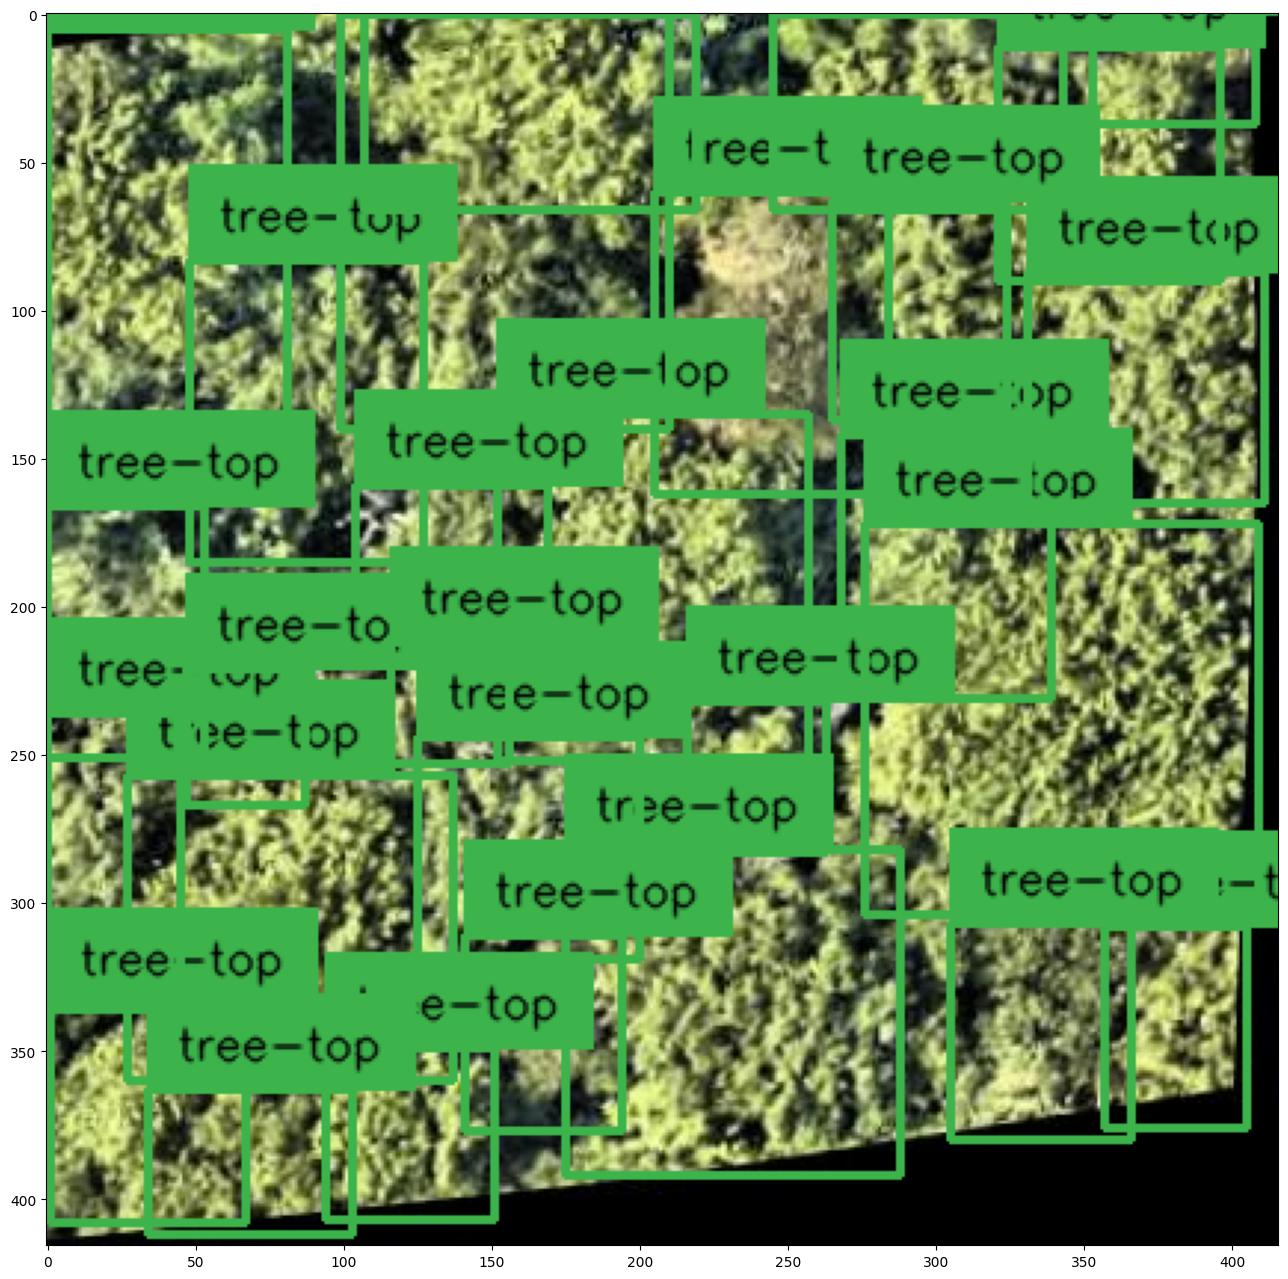

In [18]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [19]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model with PyTorch Lightning

**NOTE:** Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [28]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

CHECKPOINT = 'jozhang97/deta-swin-large-o365'
repo_name = "jozhang97/deta-swin-large-o365"
class Deta(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetaForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

**NOTE:** Let's start `tensorboard`.

In [21]:
%cd {HOME}

%load_ext tensorboard
%tensorboard --logdir lightning_logs/

/content


Reusing TensorBoard on port 6006 (pid 4728), started 0:12:02 ago. (Use '!kill 4728' to kill it.)

<IPython.core.display.Javascript object>

In [26]:
model = Deta(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-swin-large-o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.0.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([366, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([366]) in the checkpoint and torch.Size([2]) in the model instantiated
- mo

In [23]:
outputs.logits.shape

torch.Size([1, 300, 366])

In [27]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 50

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/content


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetaForObjectDetection | 218 M 
-------------------------------------------------
218 M     Trainable params
0         Non-trainable params
218 M     Total params
874.461   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

OutOfMemoryError: ignored

## Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
model.to(DEVICE)

In [ ]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## Evaluation on test dataset

Finally, we evaluate the model on the `TEST_DATASET`. For this we make use of the `CocoEvaluator` class available in a tiny [PyPi package](https://github.com/NielsRogge/coco-eval) made by [Niels Rogge](https://github.com/NielsRogge) . This class is entirely based on the [original evaluator](https://github.com/facebookresearch/detr/blob/main/datasets/coco_eval.py) class used by the DETR authors.

In [ ]:
!pip install -q coco_eval

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

## Save and load model

In [ ]:
MODEL_PATH = os.path.join(HOME, 'custom-model')

In [ ]:
model.model.save_pretrained(MODEL_PATH)

In [ ]:
model = DetaForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections...
